# Linear Regression Practice - Plus Data Preprocessing/Preparation

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## Business Problem

We have used car data scraped from Belarus, in order to explore the used car market.

Our goal is to build a model that effectively predicts the price of the used car based on its parameters (both numerical and categorical).

## Data Understanding

[Original Data Source](https://www.kaggle.com/datasets/lepchenkov/usedcarscatalog)

In [2]:
df = pd.read_csv("data/used_cars.csv")

In [5]:
df.head()

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_type,engine_capacity,body_type,price_usd
0,Subaru,Outback,automatic,NaN,190000,2010,gasoline,2.5,universal,10900.00
1,Subaru,Outback,automatic,blue,290000,2002,gasoline,3.0,universal,5000.00
2,Subaru,Forester,automatic,red,402000,2001,gasoline,2.5,suv,2800.00
3,Subaru,Impreza,mechanical,NaN,10000,1999,gasoline,3.0,sedan,9999.00
4,Subaru,Legacy,automatic,black,280000,2001,gasoline,2.5,universal,2134.11


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38531 entries, 0 to 38530
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   manufacturer_name  38531 non-null  object 
 1   model_name         38531 non-null  object 
 2   transmission       38531 non-null  object 
 3   color              34678 non-null  object 
 4   odometer_value     38531 non-null  int64  
 5   year_produced      38531 non-null  int64  
 6   engine_type        38531 non-null  object 
 7   engine_capacity    38521 non-null  float64
 8   body_type          38531 non-null  object 
 9   price_usd          38531 non-null  float64
dtypes: float64(2), int64(2), object(6)
memory usage: 2.9+ MB


In [4]:
df.describe()

,odometer_value,year_produced,engine_capacity,price_usd
count,38531.000000,38531.000000,38521.000000,38531.000000
mean,248864.638447,2002.943734,2.055161,6639.971021
std,136072.376530,8.065731,0.671178,6428.152018
min,0.000000,1942.000000,0.200000,1.000000
25%,158000.000000,1998.000000,1.600000,2100.000000
50%,250000.000000,2003.000000,2.000000,4800.000000
75%,325000.000000,2009.000000,2.300000,8990.000000
max,1000000.000000,2019.000000,8.000000,50000.000000


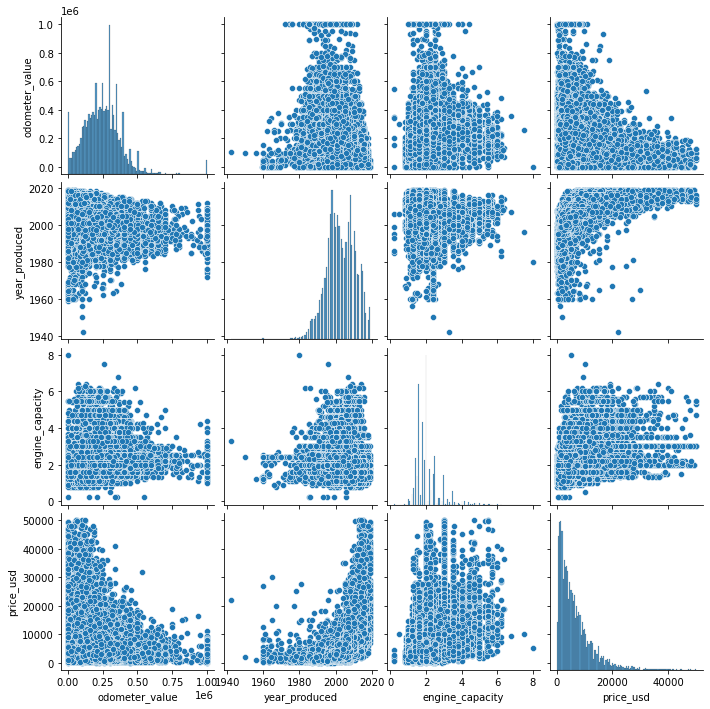

In [6]:
sns.pairplot(df);

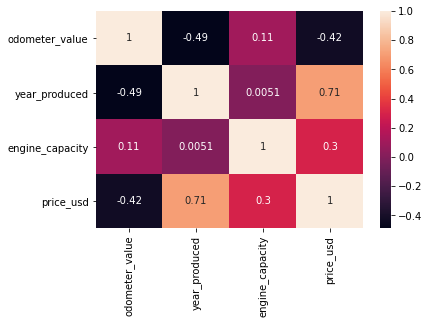

In [7]:
sns.heatmap(df.corr(), annot=True);

In [8]:
df.describe(include=[object])

,manufacturer_name,model_name,transmission,color,engine_type,body_type
count,38531,38531,38531,34678,38531,38531
unique,55,1118,2,12,3,12
top,Volkswagen,Passat,mechanical,black,gasoline,sedan
freq,4243,1423,25633,6953,25647,13011


## Data Preparation

### Deciding which columns to use

Looking at the object columns, we can see that there are way too many `manufacturer_name`s and `model_name`s to One Hot Encode those. While those columns may be useful, they would require some extra work to get them in our model - let's just drop those columns for now.

In [9]:
# Drop columns
df = df.drop(columns=['manufacturer_name', 'model_name'])

In [10]:
df.head()

,transmission,color,odometer_value,year_produced,engine_type,engine_capacity,body_type,price_usd
0,automatic,NaN,190000,2010,gasoline,2.5,universal,10900.00
1,automatic,blue,290000,2002,gasoline,3.0,universal,5000.00
2,automatic,red,402000,2001,gasoline,2.5,suv,2800.00
3,mechanical,NaN,10000,1999,gasoline,3.0,sedan,9999.00
4,automatic,black,280000,2001,gasoline,2.5,universal,2134.11


### Impute Null Values

One thing we haven't done so far this week is deal with many null values! However, if we try to throw our data into a model and it has null values, it will break the model.

In [11]:
# Check out our null values
df.isna().sum()

transmission          0
color              3853
odometer_value        0
year_produced         0
engine_type           0
engine_capacity      10
body_type             0
price_usd             0
dtype: int64

#### Discuss: How should we deal with these null values?

- Fill nulls in `color` with "Unknown" - then make that the 'implied' column that's dropped from our OHE
- Could also build a Missing Indicator
- Could just drop rows without engine capacity


SKLearn Imputation User Guide: https://scikit-learn.org/stable/modules/impute.html#impute

In [13]:
# Dropping rows where engine capacity is null
# Easiest to do this before a train test split, honestly
df = df.dropna(subset=['engine_capacity'])

In [14]:
df.columns

Index(['transmission', 'color', 'odometer_value', 'year_produced',
       'engine_type', 'engine_capacity', 'body_type', 'price_usd'],
      dtype='object')

In [15]:
# While we could easily run the simple impute on the full dataset (no data leakage),
# This seems like a good time for a train test split!

X = df.drop(columns='price_usd')
y = df['price_usd']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [16]:
# Can use simple imputer to fill nulls in color!
# Import it here
from sklearn.impute import SimpleImputer

In [17]:
# Instantiate it with our strategy
imputer = SimpleImputer(strategy='constant', fill_value="unknown", add_indicator=True)
# Then fit and transform
imputer.fit(X_train)

X_train_nonull = imputer.transform(X_train)
X_test_nonull = imputer.transform(X_test)

In [25]:
X_cols = [*X_train.columns, 'color_missing_indicator']
pd.DataFrame(X_train_nonull, columns=X_cols).head(20)

,transmission,color,odometer_value,year_produced,engine_type,engine_capacity,body_type,color_missing_indicator
0,mechanical,blue,156000,2003,gasoline,1,minivan,False
1,automatic,brown,90000,2014,gasoline,1.6,hatchback,False
2,mechanical,black,160000,2009,diesel,1.5,hatchback,False
3,mechanical,blue,218000,2011,diesel,2,universal,False
4,mechanical,white,147000,2000,gasoline,1.4,hatchback,False
5,mechanical,green,420000,1999,diesel,2,universal,False
6,mechanical,blue,220000,1998,gasoline,1.8,universal,False
7,mechanical,green,100000,1996,gasoline,1.8,hatchback,False
8,mechanical,silver,300000,2003,gasoline,1.6,hatchback,False
9,automatic,black,200000,2010,gasoline,2,universal,False


### Encode Our Categorical Data


In [18]:
# Even though X_train_nonull is a np array, we can explore it a bit
# Looping over each column to explore unique values
for col in range(X_train_nonull.shape[1]):
    col_uniques = np.unique(X_train_nonull[:,col])
    print(len(col_uniques))
    print(col_uniques)

2
['automatic' 'mechanical']
13
['black' 'blue' 'brown' 'green' 'grey' 'orange' 'other' 'red' 'silver'
 'unknown' 'violet' 'white' 'yellow']
4400
[0 1 3 ... 976543 999999 1000000]
61
[1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972
 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986
 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000
 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017 2018 2019]
2
['diesel' 'gasoline']
58
[0.2 0.5 0.8 0.9 1.0 1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.0 2.1 2.2 2.3
 2.4 2.5 2.6 2.7 2.8 2.9 3.0 3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9 4.0 4.1
 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.0 5.2 5.3 5.4 5.461 5.5 5.6 5.7 5.8 5.9
 6.0 6.2 6.8 7.5]
12
['cabriolet' 'coupe' 'hatchback' 'liftback' 'limousine' 'minibus'
 'minivan' 'pickup' 'sedan' 'suv' 'universal' 'van']
2
[False True]


What we can see is that, for our four categorical columns (`transmission`, `color`, `engine_type`, and `body_type`), the maximum number of uniques is 13 - none of these have so many categories that we can't just one-hot encode these!

In [26]:
# Let's use the same process we did yesterday
# I went ahead and provided the imports
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [27]:
X_cols

['transmission',
 'color',
 'odometer_value',
 'year_produced',
 'engine_type',
 'engine_capacity',
 'body_type',
 'color_missing_indicator']

In [28]:
# Define our categorical columns - by index number, because np array
cat_cols = [0, 1, 4, 6]

# Instantiate our encoder
encoder = OneHotEncoder(handle_unknown='error',
                        drop='first',
                        categories='auto')

# Create an columntransformer object
ct = ColumnTransformer(transformers=[('ohe', encoder, cat_cols)],
                       remainder='passthrough', sparse_threshold=0)

# Now fit and transform!
ct.fit(X_train_nonull)

X_train_enc = ct.transform(X_train_nonull)
X_test_enc = ct.transform(X_test_nonull)

In [40]:
# We can explore what this looks like now, at a glance
pd.DataFrame(X_train_enc, columns=ct.get_feature_names()).info()
# A note - newer versions of sklearn allow you to get better feature names
# But we'll stick with the version of sklearn that's in IllumiDesk for now
# Also I know these all appear to be objects - it's weird. They really aren't.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25809 entries, 0 to 25808
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ohe__x0_mechanical  25809 non-null  object
 1   ohe__x1_blue        25809 non-null  object
 2   ohe__x1_brown       25809 non-null  object
 3   ohe__x1_green       25809 non-null  object
 4   ohe__x1_grey        25809 non-null  object
 5   ohe__x1_orange      25809 non-null  object
 6   ohe__x1_other       25809 non-null  object
 7   ohe__x1_red         25809 non-null  object
 8   ohe__x1_silver      25809 non-null  object
 9   ohe__x1_unknown     25809 non-null  object
 10  ohe__x1_violet      25809 non-null  object
 11  ohe__x1_white       25809 non-null  object
 12  ohe__x1_yellow      25809 non-null  object
 13  ohe__x2_gasoline    25809 non-null  object
 14  ohe__x3_coupe       25809 non-null  object
 15  ohe__x3_hatchback   25809 non-null  object
 16  ohe__x3_liftback    25

### Scale Our Data

In [31]:
# Import the scaler we want to use
# Which should we use? Why?
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [38]:
# Instantiate, fit, then transform
scaler = MinMaxScaler()
scaler.fit(X_train_enc)

X_train_sc = scaler.transform(X_train_enc)
X_test_sc = scaler.transform(X_test_enc)

In [39]:
pd.DataFrame(X_train_sc).describe()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
count,25809.000000,25809.000000,25809.00000,25809.000000,25809.000000,25809.000000,25809.000000,25809.000000,25809.000000,25809.000000,...,25809.000000,25809.000000,25809.000000,25809.000000,25809.000000,25809.000000,25809.000000,25809.000000,25809.000000,25809.000000
mean,0.667907,0.135728,0.02131,0.064551,0.087489,0.004495,0.061374,0.067496,0.160719,0.100585,...,0.095432,0.003255,0.338138,0.131737,0.143012,0.021117,0.249023,0.732685,0.254064,0.100585
std,0.470973,0.342506,0.14442,0.245737,0.282556,0.066892,0.240020,0.250884,0.367279,0.300784,...,0.293816,0.056958,0.473085,0.338211,0.350092,0.143776,0.135755,0.133992,0.091690,0.300784
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.158796,0.650000,0.191781,0.000000
50%,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.733333,0.246575,0.000000
75%,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.325000,0.833333,0.287671,0.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Modeling

### Model-Less Baseline

In [41]:
# Get the mean of our training y
y_bar = y_train.mean()

In [43]:
# Grab predictions
baseline_train_preds = [y_bar] * len(y_train)
baseline_test_preds = [y_bar] * len(y_test)

In [44]:
# Evaluate
print(f"Train R2 Score: {r2_score(y_train, baseline_train_preds):.4f}")
print(f"Train MAE Score: ${mean_absolute_error(y_train, baseline_train_preds):.4f}")
print(f"Train RMSE Score: ${mean_squared_error(y_train, baseline_train_preds, squared=False):.4f}")
print("*"*20)
print(f"Test R2 Score: {r2_score(y_test, baseline_test_preds):.4f}")
print(f"Test MAE Score: ${mean_absolute_error(y_test, baseline_test_preds):.4f}")
print(f"Test RMSE Score: ${mean_squared_error(y_test, baseline_test_preds, squared=False):.4f}")

Train R2 Score: 0.0000
Train MAE Score: $4564.1352
Train RMSE Score: $6375.7058
********************
Test R2 Score: -0.0001
Test MAE Score: $4629.5770
Test RMSE Score: $6524.3513


#### Evaluate: Thoughts?

- 


### Baseline Linear Regression Model

In [46]:
# Import the modeling library we want to use
from sklearn.linear_model import LinearRegression

In [47]:
# Create and fit our model
lr_base = LinearRegression()
lr_base.fit(X_train_sc, y_train)

LinearRegression()

In [48]:
# Grab predictions
train_preds = lr_base.predict(X_train_sc)
test_preds = lr_base.predict(X_test_sc)

In [49]:
# Evaluate
print(f"Train R2 Score: {r2_score(y_train, train_preds):.4f}")
print(f"Train MAE Score: ${mean_absolute_error(y_train, train_preds):.4f}")
print(f"Train RMSE Score: ${mean_squared_error(y_train, train_preds, squared=False):.4f}")
print("*"*20)
print(f"Test R2 Score: {r2_score(y_test, test_preds):.4f}")
print(f"Test MAE Score: ${mean_absolute_error(y_test, test_preds):.4f}")
print(f"Test RMSE Score: ${mean_squared_error(y_test, test_preds, squared=False):.4f}")

Train R2 Score: 0.6565
Train MAE Score: $2376.5352
Train RMSE Score: $3736.6390
********************
Test R2 Score: 0.6507
Test MAE Score: $2430.4681
Test RMSE Score: $3855.8220


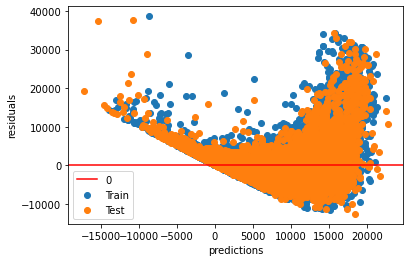

In [50]:
# visualize residuals
plt.scatter(train_preds, y_train-train_preds, label='Train')
plt.scatter(test_preds, y_test-test_preds, label='Test')

plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.legend()
plt.show()

#### Evaluate: Thoughts?

- 


### Next Model: Log Y

We saw that our y value was pretty right-skewed to start with:

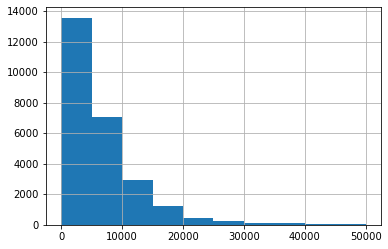

In [51]:
y_train.hist();

### Log Transforming

Linear regression can work better if the predictor and target are normally distributed. 

**Log-transforming** can be a good tool to make *right-skewed* data more normal.

(For *left-skewed* data, which is rarer, we can try transforming our data by raising it to an exponent greater than 1.)

Let's see what transforming it would look like.

Log transformation using numpy's `log1p` - [documentation](https://numpy.org/doc/stable/reference/generated/numpy.log1p.html) (Why `log1p`? Because math - [check out this post](https://stackoverflow.com/a/49538384/14222529). Also FYI inverse would be `expm1`)

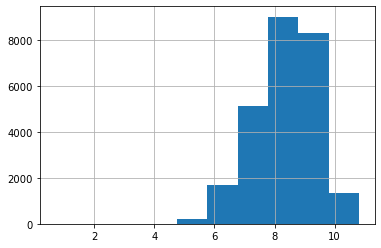

In [52]:
np.log1p(y_train).hist();

Much more normal! (although still some extreme outliers it looks like)

Let's log both our train and test y, then see if our model improves.

In [53]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [56]:
# Model
lr_log = LinearRegression()

lr_log.fit(X_train_sc, y_train_log)

# Grab predictions
train_preds_log = lr_log.predict(X_train_sc)
test_preds_log = lr_log.predict(X_test_sc)

In [57]:
# Evaluate
# Note that, for the two in dollar terms (MAE and RMSE), I unlog the predictions
print(f"Train R2 Score: {r2_score(y_train_log, train_preds_log):.4f}")
print(f"Train MAE Score: ${mean_absolute_error(np.expm1(y_train_log), np.expm1(train_preds_log)):.4f}")
print(f"Train RMSE Score: ${mean_squared_error(np.expm1(y_train_log), np.expm1(train_preds_log), squared=False):.4f}")
print("*"*20)
print(f"Test R2 Score: {r2_score(y_test_log, test_preds_log):.4f}")
print(f"Test MAE Score: ${mean_absolute_error(np.expm1(y_test_log), np.expm1(test_preds_log)):.4f}")
print(f"Test RMSE Score: ${mean_squared_error(np.expm1(y_test_log), np.expm1(test_preds_log), squared=False):.4f}")

Train R2 Score: 0.7817
Train MAE Score: $1667.6880
Train RMSE Score: $2832.5569
********************
Test R2 Score: 0.7716
Test MAE Score: $1693.8329
Test RMSE Score: $2882.1696


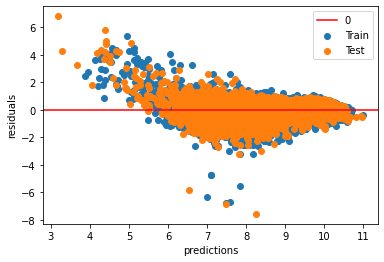

In [58]:
# visualize residuals
plt.scatter(train_preds_log, y_train_log-train_preds_log, label='Train')
plt.scatter(test_preds_log, y_test_log-test_preds_log, label='Test')

plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.legend()
plt.show()

#### Evaluate: Thoughts?

- 


### Interpreting after Log Transformations

But with this transformed target, how do I now interpret my LR coefficients?


In [59]:
# Look at coefs for our ohe model
dict(zip(ct.get_feature_names(), lr_base.coef_))

{'ohe__x0_mechanical': -1522.3182021525363,
 'ohe__x1_blue': -458.7191819005202,
 'ohe__x1_brown': 804.6543179582699,
 'ohe__x1_green': -474.7230235344702,
 'ohe__x1_grey': -135.25554958788155,
 'ohe__x1_orange': 6.189744215157863,
 'ohe__x1_other': -656.8261525235838,
 'ohe__x1_red': -71.83391177830356,
 'ohe__x1_silver': -1034.1829736847274,
 'ohe__x1_unknown': 2.1183227962822452e+16,
 'ohe__x1_violet': -448.23774902464675,
 'ohe__x1_white': 399.94724815369665,
 'ohe__x1_yellow': -186.78945536334817,
 'ohe__x2_gasoline': -1265.435244159623,
 'ohe__x3_coupe': -2523.1029538024313,
 'ohe__x3_hatchback': -5003.651848562851,
 'ohe__x3_liftback': -3828.2845896773924,
 'ohe__x3_limousine': -5573.010482443051,
 'ohe__x3_minibus': -1550.564405146406,
 'ohe__x3_minivan': -4492.532715381447,
 'ohe__x3_pickup': -918.7092538666934,
 'ohe__x3_sedan': -3989.045012727198,
 'ohe__x3_suv': -1169.4404214673505,
 'ohe__x3_universal': -4608.1703370750765,
 'ohe__x3_van': -3309.9181426285813,
 'x2': -6590

In [60]:
# Now for coefs of our log model
dict(zip(ct.get_feature_names(), lr_log.coef_))

{'ohe__x0_mechanical': -0.2046007475818538,
 'ohe__x1_blue': -0.10847286179217885,
 'ohe__x1_brown': -0.0019321264590963275,
 'ohe__x1_green': -0.15977478580357807,
 'ohe__x1_grey': -0.05142589723267577,
 'ohe__x1_orange': -0.07388068060848693,
 'ohe__x1_other': -0.10009799307111263,
 'ohe__x1_red': -0.1598495510428144,
 'ohe__x1_silver': -0.07478456944679338,
 'ohe__x1_unknown': -7425464211236.984,
 'ohe__x1_violet': -0.1590053005507187,
 'ohe__x1_white': -0.09532865748083358,
 'ohe__x1_yellow': -0.12236930357570212,
 'ohe__x2_gasoline': -0.2176918152829235,
 'ohe__x3_coupe': -0.38666585647848684,
 'ohe__x3_hatchback': -0.7668403634437503,
 'ohe__x3_liftback': -0.5965280101442931,
 'ohe__x3_limousine': -0.4591903601316101,
 'ohe__x3_minibus': -0.1892609328197233,
 'ohe__x3_minivan': -0.49133473940232086,
 'ohe__x3_pickup': -0.32580776951694407,
 'ohe__x3_sedan': -0.6123292532427242,
 'ohe__x3_suv': -0.38238632120751626,
 'ohe__x3_universal': -0.6480593061610285,
 'ohe__x3_van': -0.399

Before the transformation, I would have said that a one-unit increase (and note - units are based on however we scaled our inputs!) in the X column results on average in a `Xcoef` increase in our target. 

But what I need to say now is that a one-unit increase in our X column results on average in a `Xcoef` increase *in the logarithm of of our target*, i.e. an increase in price by a factor of $e^{\text{Xcoef}}$.

More practically, you can interpret the exponent as a percentage! If you take the exponent of the coefficient minus one, that gives you the percentage increase.

Formula:

$e ^ \text{Xcoef} - 1$

In code:
```
(np.exp(Xcoef) - 1) * 100
```



In [65]:
# For example:
log_coef_dict = dict(zip(ct.get_feature_names(), lr_log.coef_))

for feature, coef in log_coef_dict.items():
    print(f"A One-Unit Increase in {feature} results on average in a {(np.exp(coef) - 1) * 100:.4f}% change in price")

A One-Unit Increase in ohe__x0_mechanical results on average in a -18.5027% change in price
A One-Unit Increase in ohe__x1_blue results on average in a -10.2797% change in price
A One-Unit Increase in ohe__x1_brown results on average in a -0.1930% change in price
A One-Unit Increase in ohe__x1_green results on average in a -14.7664% change in price
A One-Unit Increase in ohe__x1_grey results on average in a -5.0126% change in price
A One-Unit Increase in ohe__x1_orange results on average in a -7.1217% change in price
A One-Unit Increase in ohe__x1_other results on average in a -9.5251% change in price
A One-Unit Increase in ohe__x1_red results on average in a -14.7728% change in price
A One-Unit Increase in ohe__x1_silver results on average in a -7.2057% change in price
A One-Unit Increase in ohe__x1_unknown results on average in a -100.0000% change in price
A One-Unit Increase in ohe__x1_violet results on average in a -14.7008% change in price
A One-Unit Increase in ohe__x1_white resu

<ipython-input-65-d0061b18910e>:5: RuntimeWarning: overflow encountered in exp
  print(f"A One-Unit Increase in {feature} results on average in a {(np.exp(coef) - 1) * 100:.4f}% change in price")


Note that our binary columns start to get really weird. In practice, before interpreting variables in any practical sense, we'd run one last model without scaling to allow us to better interpret our results - but we'll still likely keep our logged `y` as our target if it improves our model!

Reference:
- https://stats.oarc.ucla.edu/sas/faq/how-can-i-interpret-log-transformed-variables-in-terms-of-percent-change-in-linear-regression/

### Next Model

Now what?

In [ ]:
# code here to keep iterating!